In [24]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Deep Neural Networks 
## Session 08c

## Working with Tensorflow 
- One hidden layer
- ${Swish}$ activation function
- Adam
- Multi-class output
- FIFA dataset
- use of datasets

<img src='../../prasami_images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [25]:
###-----------------
### Import Libraries
###-----------------

import os
import sys
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from time import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

import tensorflow as tf

from utils.helper import fn_plot_tf_hist, fn_plot_confusion_matrix

In [26]:
###----------------------
### Some basic parameters
###----------------------

inpDir = '../../input' # location where input data is stored
outDir = '../output' # location to store outputs
modelDir = '../models' # location of the images
subDir = 'fifa_2019'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results
tf.random.set_seed(RANDOM_STATE) # setting for Tensorflow as well


EPOCHS = 100 # number of epochs
ALPHA = 0.1 # learning rate

BATCH_SIZE = 256

TEST_SIZE = 0.2

# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (15,15),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }

CMAP = plt.cm.coolwarm

plt.rcParams.update(params) # update rcParams

plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

## Basic Hygiene

In [27]:
# Check if all directories are present
if not os.path.exists(os.path.join(outDir)):
    os.makedirs(os.path.join(outDir))
    print ('Created {} directory'.format(outDir))

if not os.path.exists(os.path.join(modelDir, subDir)):
    os.makedirs(os.path.join(modelDir, subDir))
    print ('Created {} directory'.format(os.path.join(modelDir, subDir)))
    

In [28]:
### Settings so that Tensorflow can not Hog all the GPU memory
physical_devices = tf.config.list_physical_devices('GPU') 

if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Read FIFA 2019 data set

In [29]:
data_df = pd.read_csv(os.path.join(inpDir, 'fifa_2019.csv'))
data_df.shape

(18207, 89)

In [30]:
# removing rows with position = null
data_df = data_df[data_df["Position"].notnull()]
data_df.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [31]:
# Following columns appear to be relevant for our analysis
rel_cols = ['Position', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
            'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
            'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
            'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
            'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
            'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
            'GKKicking', 'GKPositioning', 'GKReflexes']

data_df = data_df[rel_cols]
data_df.head()

,Position,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,RF,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,ST,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,LW,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,GK,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,RCM,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [32]:
# Are there NaNs Still?

data_df.isna().sum()

Position           0
Finishing          0
HeadingAccuracy    0
ShortPassing       0
Volleys            0
Dribbling          0
Curve              0
FKAccuracy         0
LongPassing        0
BallControl        0
Acceleration       0
SprintSpeed        0
Agility            0
Reactions          0
Balance            0
ShotPower          0
Jumping            0
Stamina            0
Strength           0
LongShots          0
Aggression         0
Interceptions      0
Positioning        0
Vision             0
Penalties          0
Composure          0
Marking            0
StandingTackle     0
SlidingTackle      0
GKDiving           0
GKHandling         0
GKKicking          0
GKPositioning      0
GKReflexes         0
dtype: int64

In [33]:
goalkeeper = 'GK'
forward = ['ST', 'LW', 'RW', 'LF', 'RF', 'RS','LS', 'CF']
midfielder = ['CM','RCM','LCM', 'CDM','RDM','LDM', 'CAM', 'LAM', 'RAM', 'RM', 'LM']
defender = ['CB', 'RCB', 'LCB', 'LWB', 'RWB', 'LB', 'RB']

In [34]:
#Assign labels to goalkeepers
data_df.loc[data_df["Position"] == "GK", "Position"] = 0

#Defenders
data_df.loc[data_df["Position"].isin(defender), "Position"] = 1

#Midfielders
data_df.loc[data_df["Position"].isin(midfielder), "Position"] = 2

#Forward
data_df.loc[data_df["Position"].isin(forward), "Position"] = 3

# Convert Column "Position" to numeric so that Pandas does not complain
data_df['Position'] = pd.to_numeric(data_df['Position'], downcast="integer")

In [35]:
class_labels = {0: 'Goal Keeper', 1: 'Defender', 2: 'Mid-Fielder', 3: 'Forward'}

In [36]:
y = data_df["Position"].to_numpy()

X = data_df.drop("Position", axis = 1)

In [37]:
#  Split the data in training and test sets to measure performance of the model.
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=TEST_SIZE,
                                                    stratify=y,
                                                    random_state=RANDOM_STATE )

print (X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(14517, 33) (14517,) (3630, 33) (3630,)


In [38]:
sc = StandardScaler()

X_train = sc.fit_transform(X_train)

X_test = sc.transform(X_test)

In [39]:
type(X_train), type(X_test), type(y_train),type(y_test)

(numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray)

## Converting to Datasets

In [40]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train,y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test,y_test))

### Preprocessing and Batching

Apply various transformations, such as shuffling and batching, to the dataset:

In [41]:
# Shuffle and batch the dataset
train_ds = train_ds.shuffle(buffer_size=X_train.shape[0]).batch(BATCH_SIZE)
test_ds = test_ds.shuffle(buffer_size=X_test.shape[0]).batch(BATCH_SIZE)

In [42]:
## Optimize for performance

train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [43]:
next(iter(train_ds))

2024-05-20 15:08:40.809473: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


(<tf.Tensor: shape=(256, 33), dtype=float64, numpy=
 array([[-1.40940648, -2.37242944, -2.22160236, ...,  2.2335296 ,
          2.50974981,  2.41343878],
        [ 1.04881658,  0.96385295, -1.27004689, ..., -0.19532294,
         -0.43407708, -0.03964503],
        [ 0.94639062, -1.16446513,  0.08931806, ..., -0.19532294,
         -0.66958323, -0.59716408],
        ...,
        [-0.74363774, -0.9918988 ,  0.97290528, ..., -0.62037214,
         -0.43407708, -0.20690075],
        [-0.89727668,  0.56119818,  0.4291593 , ..., -0.13460163,
         -0.25744747, -0.59716408],
        [ 0.9976036 ,  0.44615396,  0.90493703, ..., -0.25604426,
         -0.19857093, -0.59716408]])>,
 <tf.Tensor: shape=(256,), dtype=int8, numpy=
 array([0, 3, 2, 1, 2, 1, 2, 2, 2, 1, 1, 3, 3, 2, 0, 1, 0, 2, 2, 2, 0, 1,
        3, 3, 2, 3, 3, 3, 0, 2, 0, 2, 2, 1, 3, 3, 0, 2, 1, 1, 0, 0, 2, 3,
        2, 1, 2, 3, 1, 1, 1, 2, 1, 1, 1, 0, 2, 1, 1, 1, 2, 0, 3, 2, 3, 1,
        2, 3, 0, 2, 1, 1, 2, 3, 2, 2, 1, 1, 1, 2, 2,

In [44]:
for features, labels in train_ds.take(1):
    print (features.shape, labels.shape)

(256, 33) (256,)


2024-05-20 15:08:40.841835: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


## Prepare model

### Functional API

<p style="font-family: Arial; font-size:1.2em;">You can also instantiate a Model with the <strong>"Functional API"</strong>, where you start from Input, you chain layer calls to specify the model's forward pass, and finally you create your model from inputs and outputs:

In [45]:
inputs = tf.keras.Input(shape=(33,))
    
x = tf.keras.layers.Dense(18, activation=tf.nn.relu)(inputs)

outputs = tf.keras.layers.Dense(4)(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [46]:
predictions = model(features).numpy()
predictions.shape

(256, 4)

In [47]:
predictions[0].sum()

-1.3627696

The `tf.nn.softmax` function converts these logits to "probabilities" for each class: 

In [48]:
tf.nn.softmax(predictions).numpy()[0]

array([0.3157982 , 0.1144108 , 0.41558787, 0.15420312], dtype=float32)

In [49]:
tf.nn.softmax(predictions).numpy().sum(axis = 1)[0]

0.99999994

In [50]:
'''
Number of parameters:
    layer 1 : 33*18 +18 = 612 
    layer 2 : 18*4 + 4
We are not locking any layer hence all parameter are trainable    
'''

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 33)]              0         
                                                                 
 dense (Dense)               (None, 18)                612       
                                                                 
 dense_1 (Dense)             (None, 4)                 76        
                                                                 
Total params: 688 (2.69 KB)
Trainable params: 688 (2.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [51]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy ( from_logits = True)

In [52]:
labels

<tf.Tensor: shape=(256,), dtype=int8, numpy=
array([1, 3, 1, 1, 1, 2, 2, 0, 3, 1, 1, 3, 2, 3, 1, 2, 1, 3, 1, 2, 2, 3,
       2, 0, 1, 2, 3, 1, 1, 2, 1, 2, 3, 2, 2, 3, 0, 2, 1, 1, 1, 2, 2, 3,
       2, 2, 2, 2, 3, 0, 2, 3, 1, 2, 0, 2, 2, 1, 1, 3, 1, 2, 3, 1, 2, 2,
       1, 2, 2, 2, 1, 0, 3, 2, 2, 2, 2, 2, 0, 2, 2, 1, 3, 1, 2, 3, 3, 2,
       2, 2, 1, 2, 1, 2, 2, 0, 1, 1, 2, 1, 0, 3, 0, 2, 0, 1, 1, 1, 1, 1,
       1, 2, 3, 1, 2, 3, 2, 3, 1, 2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 0, 1, 1,
       2, 1, 0, 0, 0, 3, 2, 2, 3, 0, 1, 1, 2, 2, 2, 1, 3, 1, 2, 2, 1, 1,
       2, 2, 2, 2, 2, 3, 0, 1, 1, 2, 0, 0, 2, 0, 2, 0, 1, 2, 2, 3, 3, 1,
       2, 1, 2, 2, 3, 1, 1, 3, 2, 0, 1, 1, 1, 0, 3, 3, 3, 1, 1, 1, 2, 1,
       2, 2, 2, 2, 1, 2, 2, 1, 0, 1, 0, 2, 2, 2, 1, 1, 1, 1, 2, 2, 1, 3,
       3, 2, 3, 1, 2, 1, 3, 1, 0, 2, 1, 2, 2, 0, 2, 0, 3, 2, 2, 1, 1, 1,
       3, 1, 3, 2, 1, 1, 2, 1, 2, 1, 3, 2, 3, 2], dtype=int8)>

In [53]:
loss_fn(labels, predictions).numpy()

2.3405561

Using `model.compile`, specify the training configuration such as:
- Loss function to minimize
- Optimizer
- List of metrics to monitor

In [54]:
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

Call `fit()`, which will train the model by slicing the data into `batches` of size `batch_size`, and repeatedly iterating over the entire dataset for a given number of `epochs`. Pass some validation for monitoring validation loss and metrics at the end of each epoch.

In [55]:
history = model.fit(train_ds, 
                    validation_data=test_ds,
                    epochs=EPOCHS)

Epoch 1/100


2024-05-20 15:08:41.396331: I external/local_xla/xla/service/service.cc:168] XLA service 0x748c8c00b680 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-20 15:08:41.396366: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-05-20 15:08:41.405290: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-20 15:08:41.427931: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
I0000 00:00:1716197921.499665    3310 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


57/57 [==============================] - 1s 6ms/step - loss: 1.4755 - accuracy: 0.4184 - val_loss: 0.9105 - val_accuracy: 0.6463
Epoch 2/100
57/57 [==============================] - 0s 2ms/step - loss: 0.7244 - accuracy: 0.7433 - val_loss: 0.6028 - val_accuracy: 0.7879
Epoch 3/100
57/57 [==============================] - 0s 2ms/step - loss: 0.5323 - accuracy: 0.8040 - val_loss: 0.4893 - val_accuracy: 0.8121
Epoch 4/100
57/57 [==============================] - 0s 2ms/step - loss: 0.4516 - accuracy: 0.8250 - val_loss: 0.4342 - val_accuracy: 0.8242
Epoch 5/100
57/57 [==============================] - 0s 2ms/step - loss: 0.4082 - accuracy: 0.8399 - val_loss: 0.4012 - val_accuracy: 0.8333
Epoch 6/100
57/57 [==============================] - 0s 1ms/step - loss: 0.3813 - accuracy: 0.8478 - val_loss: 0.3792 - val_accuracy: 0.8399
Epoch 7/100
57/57 [==============================] - 0s 1ms/step - loss: 0.3632 - accuracy: 0.8540 - val_loss: 0.3637 - val_accuracy: 0.8468
Epoch 8/100
57/57 [======

In case we want to separately evaluate this model, we have `evaluate` function.

In [56]:
model.evaluate ( test_ds, verbose=2)

15/15 - 0s - loss: 0.2915 - accuracy: 0.8782 - 18ms/epoch - 1ms/step


[0.2915181517601013, 0.8782368898391724]

In [57]:
loss_df = pd.DataFrame(history.history)
loss_df.head()

,loss,accuracy,val_loss,val_accuracy
0,1.475548,0.418406,0.910508,0.646281
1,0.724426,0.743267,0.602795,0.787879
2,0.532342,0.803954,0.489280,0.812121
3,0.451597,0.825033,0.434155,0.824242
4,0.408232,0.839912,0.401226,0.833333


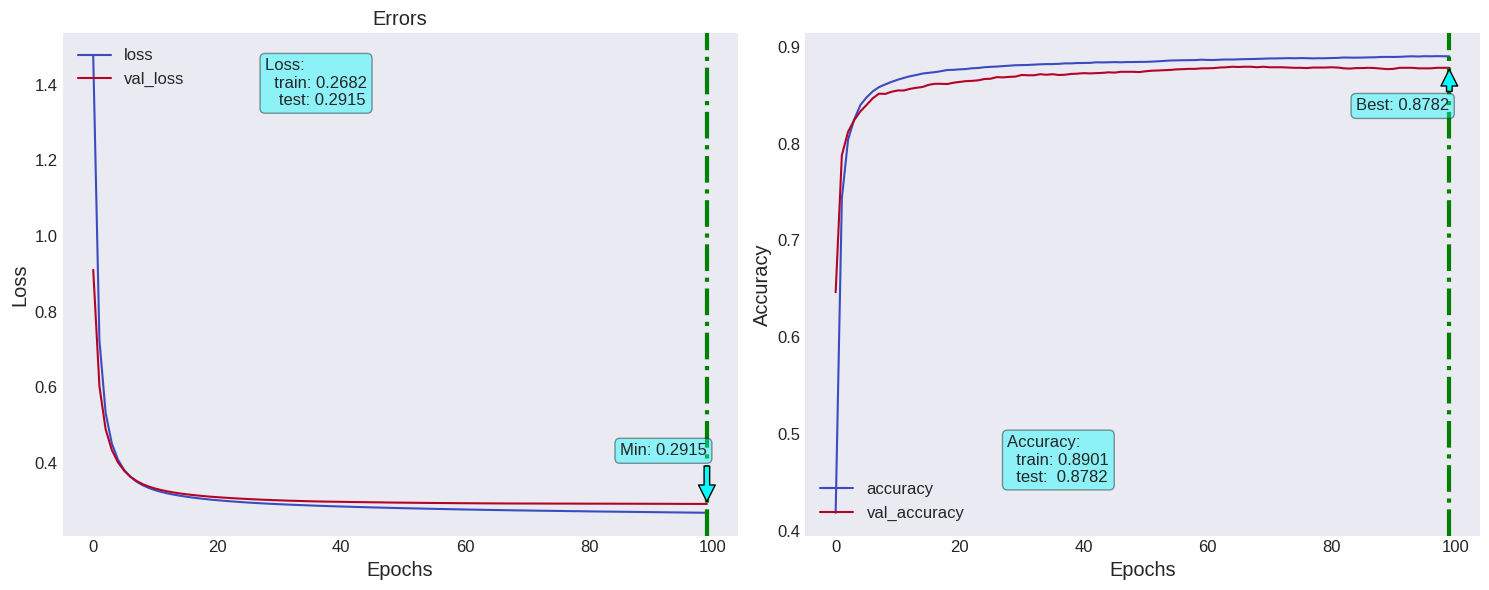

In [58]:
fn_plot_tf_hist(loss_df)

In [59]:
loss_df[loss_df['val_loss'] == loss_df['val_loss'].min()]

,loss,accuracy,val_loss,val_accuracy
99,0.268237,0.89006,0.291518,0.878237


## Predictions

In [60]:
probability_model = tf.keras.Sequential([
  model,
  tf.keras.layers.Softmax()
])

In [64]:
y_true, y_pred = [],[]
for feats, lbls in train_ds:
    pred = probability_model(feats).numpy()
    pred = pred.argmax(axis =1)
    y_pred.extend(pred)
    y_true.extend(lbls)
len(y_pred), len(y_true)

(14517, 14517)

In [65]:
print(classification_report( y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1620
           1       0.92      0.93      0.93      4693
           2       0.84      0.88      0.86      5470
           3       0.86      0.79      0.82      2734

    accuracy                           0.89     14517
   macro avg       0.91      0.90      0.90     14517
weighted avg       0.89      0.89      0.89     14517



In [39]:
y_true, y_pred = [],[]
for feats, lbls in test_ds:
    pred = probability_model(feats).numpy()
    pred = pred.argmax(axis =1)
    y_pred.extend(pred)
    y_true.extend(lbls)
len(y_pred), len(y_true)

print('Accuracy score on Test Data :{:.5f}'.format(accuracy_score(y_test, 
                                                                  np.argmax(y_pred, axis = 1))))

Accuracy score on Test Data :0.87245


In [67]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1620
           1       0.92      0.93      0.93      4693
           2       0.84      0.88      0.86      5470
           3       0.86      0.79      0.82      2734

    accuracy                           0.89     14517
   macro avg       0.91      0.90      0.90     14517
weighted avg       0.89      0.89      0.89     14517



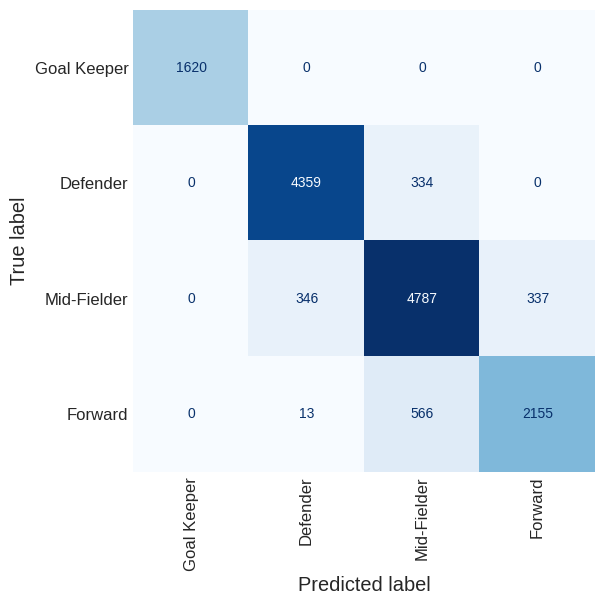

In [69]:
fn_plot_confusion_matrix( y_true, y_pred, labels=class_labels)